# Computing Galactic Orbits of Stars with Gala

## Authors
Adrian Price-Whelan, Stephanie T. Douglas

## Companion Content
Astropy Docs: [Description of the Galactocentric frame in astropy coordinates](
http://docs.astropy.org/en/latest/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py)

In [ ]:
!pip install gala astroquery

In [ ]:
!pip install gala

## Imports

In [ ]:
# astropy imports
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
import astropy.units as u
import astropy.constants as const
from astroquery.gaia import Gaia

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
%matplotlib inline

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.dynamics import mockstream as ms
from gala.units import galactic

# Google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gaia_data = QTable.read('/content/drive/MyDrive/Galáctica_proyect2/gaia_data.fits')

In [ ]:
gaia_data[:4]

source_id,ra,dec,pmra,pmdec,parallax,radial_velocity
,deg,deg,mas / yr,mas / yr,mas,km / s
int64,float64,float64,float64,float64,float64,float32
15542185269834624,47.30128985225533,10.900461795531987,-8.020415204948266,-18.292858288597156,0.39861378478397663,-81.1683120727539
25052342374772736,38.72542676111138,10.303775942066395,-5.054412462313806,-14.001691380836522,0.2915287625244508,-20.102012634277344
47948469433052800,65.78659871167118,18.927314811144104,176.0153138924227,-103.65910496915407,25.908844917029448,37.15754699707031
48191667661477120,65.5569365348155,19.483570683272482,161.07063680700966,-253.79996114297657,13.44262915759559,-22.128433227539062


In [ ]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist.min(), dist.max()

(<MaskedDistance 28.1613621 pc>, <MaskedDistance 7077.59832039 pc>)

It looks like the closest star in our sample is about 9 pc away, and the farthest is almost 100 pc, as we expected.

In [ ]:
c = coord.SkyCoord(ra=gaia_data['ra'],
                   dec=gaia_data['dec'],
                   distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'],
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])

Note: as described in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html), the Gaia column `pmra` contains the cos(dec) term. In Astropy coordinates, the name of this component is `pm_ra_cosdec`.

We'll use a distance of 8.1 kpc — more consistent with the [recent results from the GRAVITY collaboration](https://arxiv.org/abs/1807.09409) than the deafult value — and a solar height of 0 pc. We'll use the default solar velocity. We can transform our data to this frame using the `transform_to()` method by specifying the `Galactocentric` frame with our adopted values:

In [ ]:
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc,
                                             galcen_distance=8.1*u.kpc))

The `galcen` object now contains the data for our sample, but in the Galactocentric frame:

In [ ]:
galcen[:10]

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.1 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=0.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-10002.51554973,  374.47162204, -1591.77606606),
     (-10385.40952792,  820.10332398, -2422.92379483),
     ( -8135.96278871,    1.93887343,   -13.87933793),
     ( -8169.36169034,    4.4726881 ,   -26.51139852),
     ( -8128.27886488,    5.75845664,   -11.36714313),
     ( -9291.09362091,  719.01131921,  -623.34702252),
     ( -8778.67757472,   96.95775316,  -247.94598351),
     (-11063.78520792,  844.90911794,   159.99973947),
     (-11359.47958159, 1109.72231795,   626.37851782),
     ( -8487.66520476,  222.78474076,    49.55165772)]
 (v_x, v_y, v_z) in km / s
    [(202.52386605, 137.65829002, -116.33105418),
     (163.8626322 , 131.75867441, -144.68839368),
     (-28.00551077, 212.42763341,    5.80545822),
     ( 32.25075783, 139.25133676,    1.30252625),
     ( 2

En este ejemplo, todas las estrellas parecen ser del disco fino con velocidades muy altas en v_y.

We can access the positions of the stars using the `.x`, `.y`, and `.z` attributes, for example:

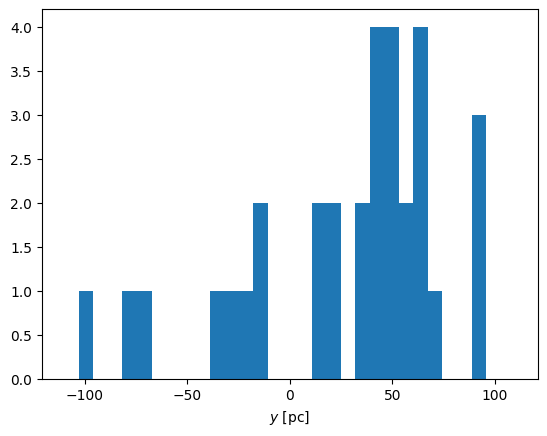

In [ ]:
plt.hist(galcen.z.value, bins=np.linspace(-110, 110, 32))
plt.xlabel('$y$ [{0:latex_inline}]'.format(galcen.y.unit));

Similarly, for the velocity components, we can use `.v_x`, `.v_y`, and `.v_z`. For example, to create a classic "UV" plane velocity plot:

Text(0, 0.5, '$v_z$ [$\\mathrm{km\\,s^{-1}}$]')

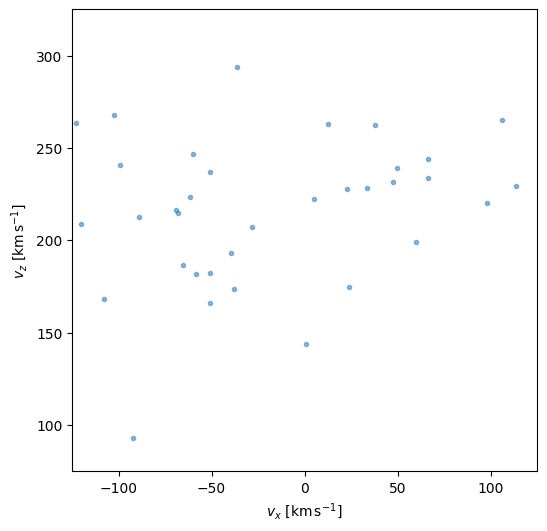

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(galcen.v_x.value, galcen.v_z.value,
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)

ax.set_xlabel('$v_x$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('$v_z$ [{0:latex_inline}]'.format(u.km/u.s))

Along with astrometric and radial velocity data, `Gaia` also provides photometric data for three photometric bandpasses: the broad-band `G`, the blue `BP`, and the red `RP` magnitudes. Let's make a Gaia color-magnitude diagram using the $G_{\rm BP}-G_{\rm RP}$ color and the absolute $G$-band magnitude $M_G$. We'll compute the absolute magnitude using the distances we computed earlier — Astropy `Distance` objects have a convenient `.distmod` attribute that provides the distance modulus:

In [ ]:
"""
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']
"""

"\nM_G = gaia_data['phot_g_mean_mag'] - dist.distmod\nBP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']\n"

In [ ]:
"""
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value,
        marker='.', linestyle='none', alpha=0.3)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')
"""

"\nfig, ax = plt.subplots(1, 1, figsize=(6, 6))\n\nax.plot(BP_RP.value, M_G.value,\n        marker='.', linestyle='none', alpha=0.3)\n\nax.set_xlim(0, 3)\nax.set_ylim(11, 1)\n\nax.set_xlabel('$G_{BP}-G_{RP}$')\nax.set_ylabel('$M_G$')\n"

In [ ]:
"""
np.seterr(invalid="ignore")
hi_mass_mask = ((BP_RP > 0.3*u.mag) & (BP_RP < 0.9*u.mag) &
                (M_G > 2*u.mag) & (M_G < 3.5*u.mag) & (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

lo_mass_mask = ((BP_RP > 2.0*u.mag) & (BP_RP < 3.0*u.mag) &
                (M_G > 8*u.mag) & (M_G < 10.4*u.mag) & (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))
"""

'\nnp.seterr(invalid="ignore")\nhi_mass_mask = ((BP_RP > 0.3*u.mag) & (BP_RP < 0.9*u.mag) &\n                (M_G > 2*u.mag) & (M_G < 3.5*u.mag) & (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))\n\nlo_mass_mask = ((BP_RP > 2.0*u.mag) & (BP_RP < 3.0*u.mag) &\n                (M_G > 8*u.mag) & (M_G < 10.4*u.mag) & (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))\n'

Let's also define default colors to use when visualizing the high- and low-mass stars:

In [ ]:
hi_mass_color = 'darkblue'
lo_mass_color = 'red'

Let's now visualize these two CMD selections:

In [ ]:
"""
fs = 14
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(BP_RP.value, M_G.value, color='gray',
        marker='.', linestyle='none', alpha=0.2)

for mask, color in zip([lo_mass_mask, hi_mass_mask],
                       [lo_mass_color, hi_mass_color]):
    ax.plot(BP_RP[mask].value, M_G[mask].value,
            marker='.', linestyle='none',
            alpha=0.5, color=color)

ax.set_xlim(-0.3, 4.1)
ax.set_ylim(14, -0.5)

ax.set_xlabel('$G_{BP}-G_{RP}$ [mag]', fontsize=fs)
ax.set_ylabel('$G$ [mag]', fontsize=fs)
ax.tick_params(labelsize=fs, size=6)
ax.minorticks_on()
ax.tick_params(which='minor', size=4)
ax.text(1.5, 3., 'High-mass stars', color=hi_mass_color, fontsize=fs)
ax.text(2.8, 7.5, 'Low-mass stars', color=lo_mass_color, fontsize=fs)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.savefig('CMD.pdf', dpi=300, bbox_inches='tight')
"""

"\nfs = 14\nfig, ax = plt.subplots(1, 1, figsize=(8, 8))\n\nax.plot(BP_RP.value, M_G.value, color='gray',\n        marker='.', linestyle='none', alpha=0.2)\n\nfor mask, color in zip([lo_mass_mask, hi_mass_mask],\n                       [lo_mass_color, hi_mass_color]):\n    ax.plot(BP_RP[mask].value, M_G[mask].value,\n            marker='.', linestyle='none',\n            alpha=0.5, color=color)\n\nax.set_xlim(-0.3, 4.1)\nax.set_ylim(14, -0.5)\n\nax.set_xlabel('$G_{BP}-G_{RP}$ [mag]', fontsize=fs)\nax.set_ylabel('$G$ [mag]', fontsize=fs)\nax.tick_params(labelsize=fs, size=6)\nax.minorticks_on()\nax.tick_params(which='minor', size=4)\nax.text(1.5, 3., 'High-mass stars', color=hi_mass_color, fontsize=fs)\nax.text(2.8, 7.5, 'Low-mass stars', color=lo_mass_color, fontsize=fs)\nax.xaxis.set_major_locator(MaxNLocator(nbins=5))\n\nplt.savefig('CMD.pdf', dpi=300, bbox_inches='tight')\n"

Thus far, we've used the color-magnitude diagram (using parallaxes and photometry from Gaia to compute absolute magnitudes) to select samples of high- and low-mass stars based on their colors.

In what follows, we'll compute Galactic orbits for stars in the high- and low-mass star selections above and compare.

## Using `gala` to numerically integrate Galactic stellar orbits

`gala` is an Astropy affiliated package for Galactic dynamics. `gala` provides functionality for representing analytic mass models that are commonly used in Galactic dynamics contexts for numerically integrating stellar orbits. For examples, see Chapter 3 of Binney and Tremaine (2008). The gravitational potential models are defined by specifying parameters like mass, scale radii, or shape parameters and can be combined. Once defined, they can be used in combination with numerical integrators provided in `gala` to compute orbits. `gala` comes with a pre-defined, multi-component, but [simple model for the Milky Way](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) that can be used for orbit integrations. Let's create an instance of the `MilkyWayPotential` model and integrate orbits for the high- and low-mass main sequence stars selected above:

In [ ]:
milky_way = gp.MilkyWayPotential()
milky_way

/usr/local/lib/python3.12/dist-packages/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(


<CompositePotential disk,bulge,nucleus,halo>

This model has mass components for the Galactic disk, bulge, nucleus, and halo, and the parameters were defined by fitting measurements of the Milky Way enclosed mass at various radii. See [this document](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) for more details. The parameters of the `MilkyWayPotential` can be changed by passing in a dictionary of parameter values to argument names set by the component names. For example, to change the disk mass to make it slightly more massive (the choice `8e10` is arbitrary!):

In [ ]:
different_disk_potential = gp.MilkyWayPotential(disk=dict(m=8e10*u.Msun))
different_disk_potential

/usr/local/lib/python3.12/dist-packages/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(


<CompositePotential disk,bulge,nucleus,halo>

To integrate orbits, we have to combine the mass model with a reference frame into a `Hamiltonian` object. If no reference frame is passed in, it's assumed that we are in a static inertial frame moving with the center of the mass model:

In [ ]:
H = gp.Hamiltonian(milky_way)

Now that we have the mass model, we can integrate orbits. Let's now define initial conditions for subsets of the high- and low-mass star selections we did above. Initial conditions in `gala` are specified by creating `PhaseSpacePosition` objects. We can create these objects directly from a `Galactocentric` object, like we have defined above from transforming the Gaia data — we first have to extract the data with a Cartesian representation. We can do this by calling `galcen.cartesian`:

In [ ]:
w0 = gd.PhaseSpacePosition(galcen.cartesian)
print(w0[:2])


pos=[(-10002.51554973, 374.47162204, -1591.77606606),
 (-10385.40952792, 820.10332398, -2422.92379483)] pc
vel=[(202.52386605, 137.65829002, -116.33105418),
 (163.8626322 , 131.75867441, -144.68839368)] km / s


In [ ]:
orbits = H.integrate_orbit(w0, dt=1*u.Myr,
                              t1=0*u.Myr, t2=1500*u.Myr)

By default this uses a [Leapfrog](https://en.wikipedia.org/wiki/Leapfrog_integration) numerical integration scheme, but the integrator can be customized — see the `gala` [examples](http://gala.adrian.pw/en/latest/examples/integrate-potential-example.html) for more details.

In [ ]:
print(orbits.shape)

(1500, 298)


In [ ]:
zmax = orbits.zmax(approximate=True)

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Aquí puedo identificar las estrellas de alta y baja masa con la mayor z_max y la menor z_max, y podría hacer lo mismo con la excursión radial, para
# graficar con fundamento los ejemplos. No vale la pena mostrar todos los casos extremos porque los veremos en el histograma, pero puedo ver alguno
# que muestre bien las tendencias de las estrellas.

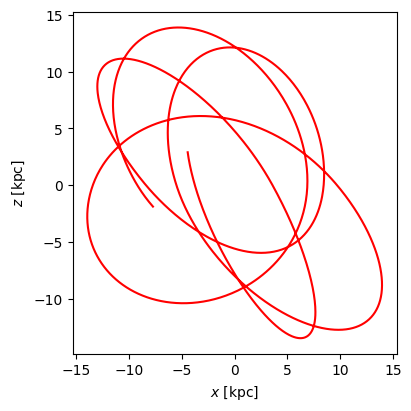

In [ ]:
fig = orbits[:, 215].plot(['x', 'z'],
                           auto_aspect=False,
                           color='red')


The representation can also be changed, for example, to a cylindrical representation:

[-0.24901579] kpc2 / Myr2


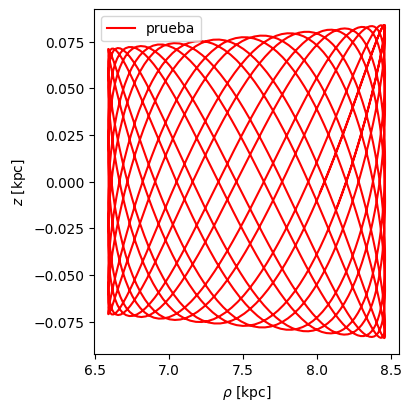

In [ ]:
fig = orbits[:, 2].cylindrical.plot(['rho', 'z'],
                                       color='red',
                                       label='prueba')

fig.axes[0].legend(loc='upper left')

"Plot to draw the equipotential curves and the orbits and see the apocenters"
"pericenters and turning points in z"
energy = milky_way.energy([1, 1, 0]*u.kpc)
print(energy)








Let's make histograms of the maximum $z$ heights for these two samples:

In [ ]:
ang_mom = orbits.angular_momentum()
max = ang_mom[2,:,1].max()
print(max)
print(ang_mom[1,:,1])


-1.5368828352766062 kpc2 / Myr
[-1.94282062 -1.93698106 -1.93113103 ... -0.16878677 -0.16761343
 -0.16644121] kpc2 / Myr


[-5.         -4.79591837 -4.59183673 -4.3877551  -4.18367347 -3.97959184
 -3.7755102  -3.57142857 -3.36734694 -3.16326531 -2.95918367 -2.75510204
 -2.55102041 -2.34693878 -2.14285714 -1.93877551 -1.73469388 -1.53061224
 -1.32653061 -1.12244898 -0.91836735 -0.71428571 -0.51020408 -0.30612245
 -0.10204082  0.10204082  0.30612245  0.51020408  0.71428571  0.91836735
  1.12244898  1.32653061  1.53061224  1.73469388  1.93877551  2.14285714
  2.34693878  2.55102041  2.75510204  2.95918367  3.16326531  3.36734694
  3.57142857  3.7755102   3.97959184  4.18367347  4.3877551   4.59183673
  4.79591837  5.        ]
[-1.53688284 -1.53688284 -1.53688284 ... -1.53688284 -1.53688284
 -1.53688284]


/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:7065: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:7066: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/usr/local/lib/python3.12/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

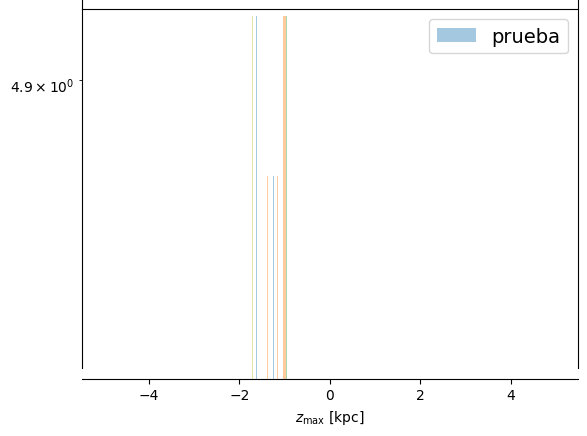

In [ ]:
bins = np.linspace(-5, 5, 50)
print(bins)
print(ang_mom[2,:,1].value)
plt.hist(ang_mom[2,:,:].value, bins=bins,
         alpha=0.4, density=True, label='prueba')

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax.unit))

The distribution of $z$-heights for the low-mass (i.e. typically older) stars is more extended, as we predicted!

In this tutorial, we've used `astroquery` to query the Gaia science archive to retrieve kinematic and photometric data for a small sample of stars with well-measured parallaxes from Gaia DR2. We used the colors and absolute magnitudes of these stars to select subsamples of high- and low-mass stars, which, on average, will provide us with subsamples of stars that are younger and older, respectively. We then constructed a model for the gravitational field of the Milky Way and numerically integrated the orbits of all stars in each of the two subsamples. Finally, we used the orbits to compute the maximum height that each star reaches above the Galactic midplane and showed that the younger (higher-mass) stars tend to have smaller excursions from the Galactic plane, consistent with the idea that stars are either born in a "thinner" disk and dynamically "heated," or that older stars formed with a larger vertical scale-height.

Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

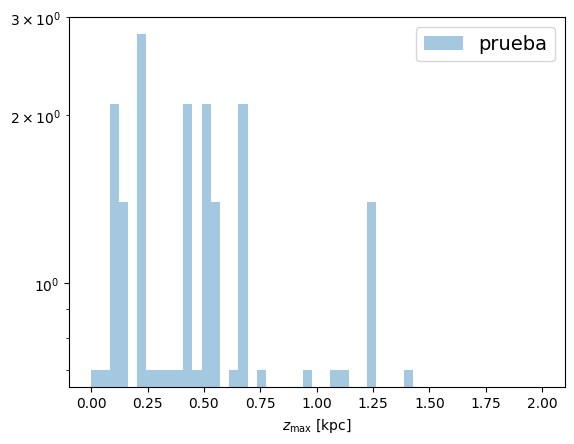

In [ ]:
bins = np.linspace(0, 2, 50)

plt.hist(zmax.value, bins=bins,
         alpha=0.4, density=True, label='prueba')

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax.unit))

## Exercises

1. Choose a stellar system of your interest. It can be a sample of stars with particular properties, a single very peculiar star, stellar clusters, MW satellite galaxies, etc.
2. Compute its/their orbits based on the example above. Take into account that the [Orbit](http://gala.adrian.pw/en/latest/dynamics/orbits-in-detail.html) objects also provide methods for computing apocenter, pericenter distances, eccentricities, and many other features.
3. Take into account possible errors using [this](http://gala.adrian.pw/en/latest/tutorials/Milky-Way-model.html) example.
3. Try changing some properties of the potential (shape, total mass) and describe whether the stellar orbits change and why.


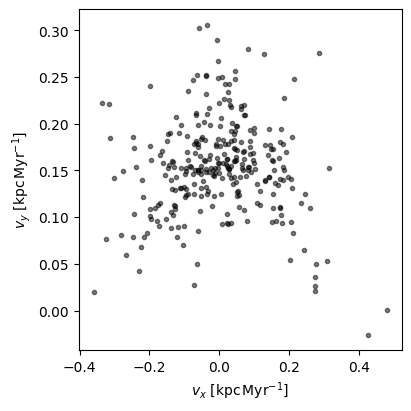

In [ ]:
fig = orbits[0, :].plot(['v_x', 'v_y'],
                           auto_aspect=False,
                           color='black',
                           marker='.',
                           alpha = 0.5)



(-20.0, 20.0)

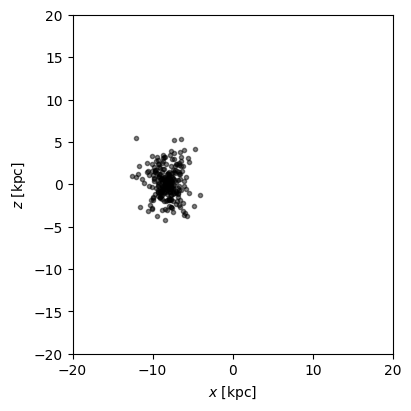

In [ ]:
fig = orbits[0, :].plot(['x', 'z'],
                           auto_aspect=False,
                           color='black',
                           marker='.',
                           alpha = 0.5)
plt.xlim(-20,20)
plt.ylim(-20,20)

In [ ]:
x = np.mean(galcen.x.to(u.kpc).value)
y = np.mean(galcen.y.to(u.kpc).value)
z = np.mean(galcen.z.to(u.kpc).value)

vx = np.mean(galcen.v_x.to(u.km/u.s).value)
vy = np.mean(galcen.v_y.to(u.km/u.s).value)
vz = np.mean(galcen.v_z.to(u.km/u.s).value)

print(x,y,z)
print(vx,vy,vz)

-8.205193246452644 0.018209135570704908 0.15683476837532848
-0.18477997665555057 150.06267450940436 -89.07142847636263


In [ ]:
prog_w0 = gd.PhaseSpacePosition(pos=[-8, 0, 0.] * u.kpc,
                                vel=[0, 150, -89] * u.km/u.s)

In [ ]:
df = ms.ChenStreamDF()
prog_mass = 5E7 * u.Msun

In [ ]:
gen = ms.MockStreamGenerator(df, H)

In [ ]:
stream, prog = gen.run(prog_w0, prog_mass,
                       dt=1 * u.Myr, n_steps=1000)

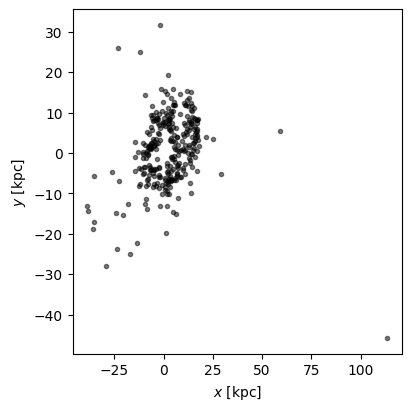

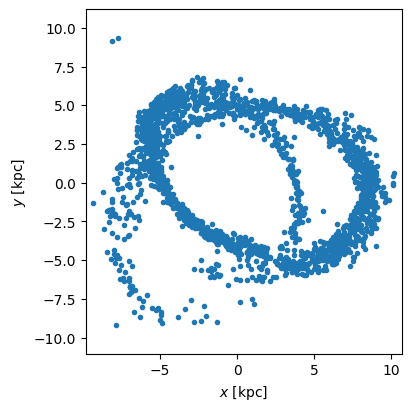

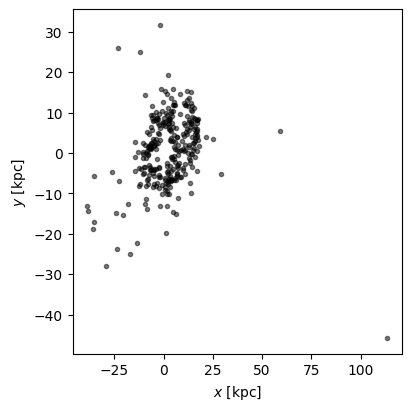

In [ ]:
stream.plot(['x', 'y'])
orbits[1000, :].plot(['x', 'y'],
                           auto_aspect=False,
                           color='black',
                           marker='.',
                           alpha = 0.5)

Animation of some stellar members of the Helmi streams or stellar currents, considering different potentials which influence their orbits trajectory. We show the x and y positions plot, animating their orbits around the body which exerts the gravitational pull on the stellar members and also showing the orbital movement of the system as a whole, in terms of its Center of Mass, where both can be compared.

In [ ]:
"Selecting some members of the Helmi Streams to plot their orbits"
with fits.open('/content/drive/MyDrive/Galáctica_proyect2/gaia_data.fits') as hdul:
  header = hdul[1].header
  data = hdul[1].data

n_members = 10
selected_members = data[:n_members]
time_span = np.linspace(0, 3000, 600)*u.Myr

"Selecting the gravitational potential that will influence"
"the orbits trajectories"
potential = gp.MilkyWayPotential()

"Integrator method (already defined in previous snippets of code)"
selected_w0 = w0[:n_members]
w0_com = prog_w0
H = gp.Hamiltonian(potential)
orbits = H.integrate_orbit(selected_w0, dt=5*u.Myr,
                           t1=0*u.Myr, t2=3000*u.Myr)
orbits_com = H.integrate_orbit(w0_com, dt=5*u.Myr,
                               t1=0*u.Myr, t2=3000*u.Myr)

"Animation function"
"Defining the lines and the markers (stored values), which are the bodies moving"
fig, ax = plt.subplots(figsize=(6, 6))

"Empty lists to store the updated values"
lines = []
points = []
color = "lightblue"

for i in range(len(selected_members)):
  if i==0:
    member_label="Helmi Stream Member"
    com_label="COM"
  else:
    member_label=""
    com_label=""
  line, = ax.plot([], [], color=color, lw=2)
  lines.append(line)
  point, = ax.plot([], [], color=color, lw=2, marker="o",
                   markeredgecolor="black", markeredgewidth=1,
                   label=member_label)
  points.append(point)
  com_line, = ax.plot([], [], color="black", lw=2, linestyle="dashed")
  com_point, = ax.plot([], [], color="black", lw=2, marker="*", label=com_label)

"Defining the animation frame labels that will be updated at each time step"
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_xlim(orbits.x.min().value-1 , orbits.x.max().value+1)
ax.set_ylim(orbits.y.min().value-1, orbits.y.max().value+1)
ax.set_title("Helmi Stream")
plt.legend(loc="upper right")

"Updating each frame creating the animation"
def animation(i):
  for j in range(len(selected_members)):
    line = lines[j]
    point = points[j]
    x_position = [orbits.x[:i+1, j].to_value(u.kpc)]
    x_sequence = [orbits.x[i, j].to_value(u.kpc)]
    y_position = [orbits.y[:i+1, j].to_value(u.kpc)]
    y_sequence = [orbits.y[i, j].to_value(u.kpc)]
    com_x_position = [orbits_com.x[:i+1].to_value(u.kpc)]
    com_y_position = [orbits_com.y[:i+1].to_value(u.kpc)]
    com_x_sequence = [orbits_com.x[i].to_value(u.kpc)]
    com_y_sequence = [orbits_com.y[i].to_value(u.kpc)]
    line.set_xdata(x_position)
    line.set_ydata(y_position)
    point.set_xdata(x_sequence)
    point.set_ydata(y_sequence)
    com_line.set_xdata(com_x_position)
    com_line.set_ydata(com_y_position)
    com_point.set_xdata(com_x_sequence)
    com_point.set_ydata(com_y_sequence)

  time_value = time_span[i].to_value(u.Myr)
  ax.set_title(f"Time: {time_value:.2f} Myr")

  return line, point, com_line, com_point

"Defining the animation"
anim = FuncAnimation(fig, animation, frames=len(orbits.t), interval=20)

"Saving specific frames of the animation"
frames = [199, 399]
for i in frames:
  animation(i)
  plt.savefig(f"frame_{i}.pdf", dpi=200)

"Closing plot to iterate frames"
plt.close()

"HTML video display"
HTML(anim.to_html5_video())


/usr/local/lib/python3.12/dist-packages/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(


In [ ]:
"Helmi Stream orbits adding Andromeda accretion with the Milky Way"

"Selecting some members of the Helmi Streams to plot their orbits"
with fits.open('/content/drive/MyDrive/Galáctica_proyect2/gaia_data.fits') as hdul:
  header = hdul[1].header
  data = hdul[1].data

n_members = 10
selected_members = data[:n_members]
time_span = np.linspace(0, 3000, 600)*u.Myr

"Selecting the gravitational potential that will influence"
"the orbits trajectories"
mw_potential = gp.MilkyWayPotential()

"Modifying the potential so we also consider the accretion of the"
"Andromeda to the Milky Way"

"We define the parameters"
andromeda_initial_distance = 800*u.kpc
andromeda_merger_time = 2500*u.Myr
G = const.G

"Andromeda Composite Potential"
bulge = gp.HernquistPotential(m=3.2e10*u.Msun, c=0.61*u.kpc, units=galactic)
disk = gp.MN3ExponentialDiskPotential(m=3.66e10*u.Msun, h_R=5.4*u.kpc,
                                      h_z=0.6*u.kpc, units=galactic)
halo = gp.NFWPotential(m=7.1e11*u.Msun, r_s=7.63*u.kpc, units=galactic)
m31 = gp.CompositePotential(halo=halo, bulge=bulge, disk=disk)

"Total Potential"
total_pot = gp.CompositePotential()

# Milky Way components
total_pot['mw_bulge'] = mw_potential['bulge']
total_pot['mw_disk'] = mw_potential['disk']
total_pot['mw_halo'] = mw_potential['halo']

# Andromeda components
total_pot['m31_bulge'] = bulge
total_pot['m31_disk'] = disk
total_pot['m31_halo'] = halo

"Integrator method (already defined in previous snippets of code)"
selected_w0 = w0[:n_members]
w0_com = prog_w0
H = gp.Hamiltonian(total_pot)

orbits = H.integrate_orbit(selected_w0, dt=5*u.Myr,
                           t1=0*u.Myr, t2=3000*u.Myr)

orbits_com = H.integrate_orbit(w0_com, dt=5*u.Myr,
                               t1=0*u.Myr, t2=3000*u.Myr)

"Animation function"
"Defining the lines and the markers (stored values), which are the bodies moving"
fig, ax = plt.subplots(figsize=(6, 6))

"Empty lists to store the updated values"
lines = []
points = []
color = "lightblue"

for i in range(len(selected_members)):
  if i==0:
    member_label="Helmi Stream Member"
    com_label="COM"
  else:
    member_label=""
    com_label=""
  line, = ax.plot([], [], color=color, lw=2)
  lines.append(line)
  point, = ax.plot([], [], color=color, lw=2, marker="o",
                   markeredgecolor="black", markeredgewidth=1,
                   label=member_label)
  points.append(point)
  com_line, = ax.plot([], [], color="black", lw=2, linestyle="dashed")
  com_point, = ax.plot([], [], color="black", lw=2, marker="*", label=com_label)

"Defining the animation frame labels that will be updated at each time step"
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_xlim(orbits.x.min().value-1 , orbits.x.max().value+1)
ax.set_ylim(orbits.y.min().value-1, orbits.y.max().value+1)
ax.set_title("Helmi Stream")
plt.legend(loc="upper right")

"Updating each frame creating the animation"
def animation(i):
  for j in range(len(selected_members)):
    line = lines[j]
    point = points[j]
    x_position = [orbits.x[:i+1, j].to_value(u.kpc)]
    x_sequence = [orbits.x[i, j].to_value(u.kpc)]
    y_position = [orbits.y[:i+1, j].to_value(u.kpc)]
    y_sequence = [orbits.y[i, j].to_value(u.kpc)]
    com_x_position = [orbits_com.x[:i+1].to_value(u.kpc)]
    com_y_position = [orbits_com.y[:i+1].to_value(u.kpc)]
    com_x_sequence = [orbits_com.x[i].to_value(u.kpc)]
    com_y_sequence = [orbits_com.y[i].to_value(u.kpc)]
    line.set_xdata(x_position)
    line.set_ydata(y_position)
    point.set_xdata(x_sequence)
    point.set_ydata(y_sequence)
    com_line.set_xdata(com_x_position)
    com_line.set_ydata(com_y_position)
    com_point.set_xdata(com_x_sequence)
    com_point.set_ydata(com_y_sequence)

  time_value = time_span[i].to_value(u.Myr)
  ax.set_title(f"Time: {time_value:.2f} Myr")

  return line, point, com_line, com_point

"Defining the animation"
anim = FuncAnimation(fig, animation, frames=len(orbits.t), interval=20)

"Saving specific frames of the animation"
frames = [199, 399]
for i in frames:
  animation(i)
  plt.savefig(f"frame_{i}.pdf", dpi=200)

"Closing plot to iterate frames"
plt.close()

"HTML video display"
HTML(anim.to_html5_video())


/usr/local/lib/python3.12/dist-packages/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


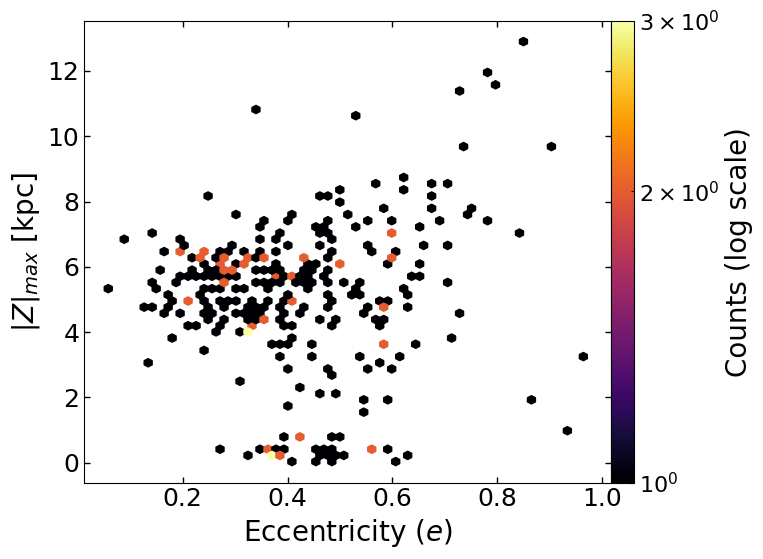

In [ ]:
"Code to plot the zmax and eccentricity of the Helmi stream members"
all_orbits = H.integrate_orbit(w0, dt=5*u.Myr,
                               t1=0*u.Myr, t2=3000*u.Myr)

"Calculating zmax and eccentricity of all its members orbits"
zmax = all_orbits.zmax()
ecc = all_orbits.eccentricity()

"Masking eccentricity and zmax values"
mask = np.isfinite(ecc) & np.isfinite(zmax)
ecc_val = ecc[mask].value
zmax_val = zmax[mask].value

"Plotting"
plt.figure(figsize=(8,6))

"Hexbin plotting with normalized density"
hb = plt.hexbin(ecc_val, zmax_val, gridsize=60,
                cmap="inferno", bins='log')

"Adding labels and colorbar"
cb = plt.colorbar(hb, pad=0)
cb.ax.tick_params(direction="in", which="both", labelsize=16)
cb.set_label("Counts (log scale)", fontsize=20)
plt.xlabel("Eccentricity ($e$)", fontsize=20)
plt.ylabel("$|Z|_{max}$ [kpc]", fontsize=20)
plt.tick_params(which='major', top=True, right=True, direction='in',
                length=4, width=1, labelsize=18)
plt.tick_params(which='minor', top=True, right=True, direction='in',
                length=4, width=1, labelsize=18)


"Save figure"
plt.savefig(f"zmax.pdf", dpi=200)

"Show"
plt.show()







In [ ]:
"Selecting some members of the Helmi Streams to plot their orbits"
with fits.open('/content/drive/MyDrive/Galáctica_proyect2/gaia_data.fits') as hdul:
  header = hdul[1].header
  data = hdul[1].data

n_members = 10
selected_members = data[:n_members]
time_span = np.linspace(0, 3000, 600)*u.Myr

"Selecting the gravitational potential that will influence"
"the orbits trajectories"
potential = gp.MilkyWayPotential2022()

"Integrator method (already defined in previous snippets of code)"
selected_w0 = w0[:n_members]
w0_com = prog_w0
H = gp.Hamiltonian(potential)
orbits = H.integrate_orbit(selected_w0, dt=5*u.Myr,
                           t1=0*u.Myr, t2=3000*u.Myr)
orbits_com = H.integrate_orbit(w0_com, dt=5*u.Myr,
                               t1=0*u.Myr, t2=3000*u.Myr)

"Animation function"
"Defining the lines and the markers (stored values), which are the bodies moving"
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

"Empty lists to store the updated values"
lines = []
points = []
color = "lightblue"

for i in range(len(selected_members)):
  if i==0:
    member_label="Helmi Stream Member"
    com_label="CoM"
  else:
    member_label=""
    com_label=""
  line, = ax.plot([], [], color=color, lw=2)
  lines.append(line)
  point, = ax.plot([], [], color=color, lw=2, marker="o",
                   markeredgecolor="black", markeredgewidth=1,
                   label=member_label)
  points.append(point)
  com_line, = ax.plot([], [], color="black", lw=2, linestyle="dashed")
  com_point, = ax.plot([], [], color="black", lw=2, marker="*", label=com_label)

"Defining the animation frame labels that will be updated at each time step"
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
ax.set_xlim(orbits.x.min().value-1 , orbits.x.max().value+1)
ax.set_ylim(orbits.y.min().value-1, orbits.y.max().value+1)
ax.set_zlim(orbits.z.min().value-1, orbits.z.max().value+1)
ax.set_title("Helmi Stream")
plt.legend()

"Updating each frame creating the animation"
def animation(i):
  for j in range(len(selected_members)):
    line = lines[j]
    point = points[j]
    x_position = orbits.x[:i+1, j].to_value(u.kpc)
    x_sequence = [orbits.x[i, j].to_value(u.kpc)]
    y_position = orbits.y[:i+1, j].to_value(u.kpc)
    y_sequence = [orbits.y[i, j].to_value(u.kpc)]
    z_position = orbits.z[:i+1, j].to_value(u.kpc)
    z_sequence = [orbits.z[i, j].to_value(u.kpc)]
    com_x_position = orbits_com.x[:i+1].to_value(u.kpc)
    com_y_position = orbits_com.y[:i+1].to_value(u.kpc)
    com_z_position = orbits_com.z[:i+1].to_value(u.kpc)
    com_x_sequence = [orbits_com.x[i].to_value(u.kpc)]
    com_y_sequence = [orbits_com.y[i].to_value(u.kpc)]
    com_z_sequence = [orbits_com.z[i].to_value(u.kpc)]
    line.set_data(x_position, y_position)
    line.set_3d_properties(z_position)
    point.set_data(x_sequence, y_sequence)
    point.set_3d_properties(z_sequence)
    com_line.set_data(com_x_position, com_y_position)
    com_line.set_3d_properties(com_z_position)
    com_point.set_data(com_x_sequence, com_y_sequence)
    com_point.set_3d_properties(com_z_sequence)

  time_value = time_span[i].to_value(u.Myr)
  ax.set_title(f"Time: {time_value:.2f} Myr")

  return lines, points, com_line, com_point

"Defining the animation"
anim = FuncAnimation(fig, animation, frames=len(orbits.t), interval=20)

"Closing plot to iterate frames"
plt.close()

"HTML video display"
HTML(anim.to_html5_video())

/usr/local/lib/python3.12/dist-packages/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(
